In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import cv2

#Initialize Data
data = np.load('/data.npy')
target=np.load('/target.npy')

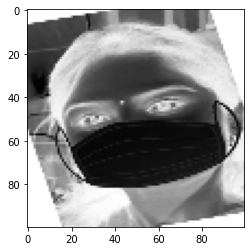

In [2]:
#Print image with mask on as visual example
plt.imshow(1-data[1100][:, :, 0], cmap='gray');

In [3]:
#Split into train-test sets
X_train, X_test, y_train, y_test=train_test_split(data,target,test_size=0.1,random_state=100)

In [4]:
#Initialize Sequential Model
model = keras.Sequential([
    Conv2D(100, kernel_size=(3,3), input_shape=data.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),  
    Conv2D(100, kernel_size=(3,3)),
    MaxPooling2D(pool_size=(2, 2)),  
    Flatten(),
    Dense(75, activation=tf.nn.relu),
    Dense(50, activation=tf.nn.relu),
    Dropout(0.5),
    Dense(2,activation=tf.nn.softmax)
])

1


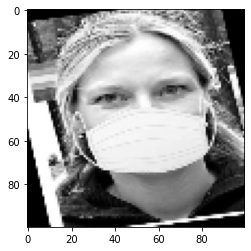

In [5]:
#Fit Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train,y=y_train, epochs=20)
print(model.evaluate(X_test,y_test))

#Test Individual predcitions
image_index = 100
plt.imshow(X_test[image_index][:, :, 0], cmap='gray')
pred = model.predict(X_test[image_index].reshape(1, 100, 100, 1))
print(pred.argmax())

In [6]:
clsfr=cv2.CascadeClassifier('cv2/data/haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)
labels_dict={0:'No_Mask',1:'Mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

frame_width = int(source.get(3))
frame_height = int(source.get(4))
out = cv2.VideoWriter('alex_mask.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    face=clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in face:
    
        face_img=gray[y:y+w,x:x+w]
        normalized=(cv2.resize(face_img,(100,100)))//255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(
          img, labels_dict[label], 
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    
    out.write(img)
    cv2.imshow('LIVE',img)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
source.release()
out.release()
cv2.destroyAllWindows()